In [10]:
from commonfunctions import *
from staff import calculate_thickness_spacing, remove_staff_lines, coordinator
from segmenter import Segmenter
from connected_componentes import  *
from fit import match, remove_repeated_matches
from symbol import Note
from box import Box
import glob
import cv2

In [11]:
quarter_templates = ['heads/black/quarter.png', 'heads/black/solid-note.png']
half_templates = ['heads/half/half-note-space.png', 'heads/half/half-space.png', 'heads/half/half.png']
whole_templates = ['heads/whole/whole-note-space.png', 'heads/whole/whole-space.png', 'heads/whole/whole.png']

templates = {
    'quarters': [cv2.imread(temp_path, 0) for temp_path in quarter_templates],
    'halfs': [cv2.imread(temp_path, 0) for temp_path in half_templates],
    'wholes': [cv2.imread(temp_path, 0) for temp_path in whole_templates]
}

In [12]:
label_map = {
    0:{
        0: 'N'
    },
    1:{
        0:'b2',
        1:'a2'
    },
    2:{
        0:'g2',
        1:'f2'
    },
    3:{
        0:'e2',
        1:'d2'
    },
    4:{
        0:'c2',
        1:'b1'
    },
    5:{
        0:'a1',
        1:'g1'
    },
    6:{
        0:'f1',
        1:'e1'
    },
    7:{
        0:'d1',
        1:'c1'
    }
}

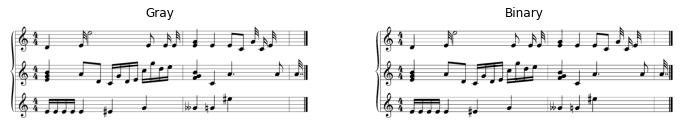

In [13]:
img = io.imread('testcases/test-set-scanned/test-cases/02.PNG')
original = img.copy()
gray = get_gray(img)
bin_img = get_thresholded(gray, threshold_otsu(gray))
show_images([gray, bin_img], ['Gray', 'Binary'])

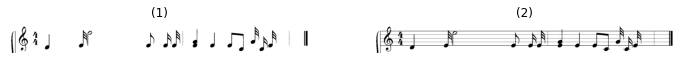

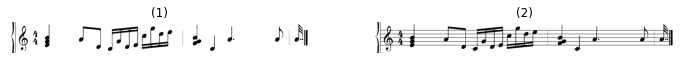

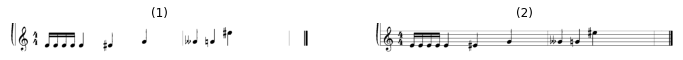

In [14]:
segmenter = Segmenter(bin_img)
imgs_with_staff = segmenter.regions_with_staff
imgs_without_staff = segmenter.regions_without_staff

for i, img in enumerate(imgs_without_staff):
    show_images([img, imgs_with_staff[i]])

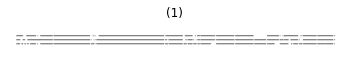

38


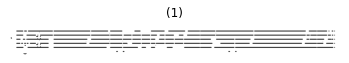

40


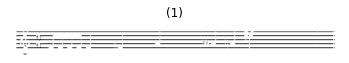

40


In [15]:
imgs_spacing = []
imgs_rows = []
for i, img in enumerate(imgs_with_staff):
    spacing, rows = coordinator(img)
    imgs_rows.append(rows)
    imgs_spacing.append(spacing)

In [16]:
def estim(c):
    margin = 1+(spacing/4)
    for index,line in enumerate (rows):
        if c >= line - margin and c <= line + margin:
            return index+1, 0
        elif c >= line + margin and c <= line + 3*margin:
            return index+1, 1
    return 0 , 0 

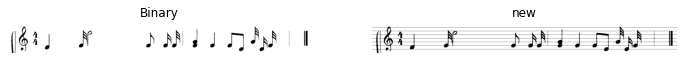

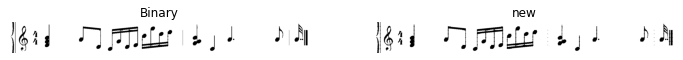

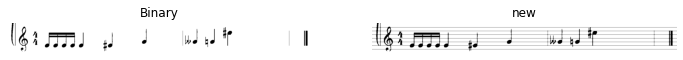

In [17]:
def draw_staff(img,row_positions):
    image = np.copy(img)
    for x in range (len(row_positions)):
        image[int(row_positions[x]),:] = 0
    return image

for i, img in enumerate(imgs_without_staff):
    new_img = draw_staff(img,imgs_rows[i])
    new_img = otsu(new_img)
    show_images([img,new_img], ['Binary','new'])  

In [26]:
for i, img in enumerate(imgs_without_staff):
    all_labels = []
    detected = np.copy(img)
    for template in templates:
        img = np.array(255*img).astype(np.uint8)
        boxes = match(img, templates[template], 50, 150, 0.7)
        boxes = remove_repeated_matches([j for i in boxes for j in i], 0.5)

        box = Box(0, 0, img.shape[1], img.shape[0])
        notes = [Note(r, "4,8, 16, 32", box, [], []) for r in boxes]
        for idx, r in enumerate(boxes):
            r.draw(detected, (0, 0, 255), 2)
            line_idx, p = estim(int(r.y+r.h))
            label = label_map[line_idx][p]
            all_labels.append((r, label))
            cv2.putText(detected, label, (r.x-5, r.y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        
    cv2.imwrite(f'detected{i}.png', detected)

    all_labels = sorted(all_labels, key=lambda b : (b[0].x, b[0].y))
    res = []
    i = 0
    while i < len(all_labels):
        label = all_labels[i]
        cur_res = [label[1]]
        h = label[0].h
        if i+1 < len(all_labels):
            dist = np.abs(all_labels[i+1][0].y - label[0].y)
            while i+1 < len(all_labels) and np.isclose([dist], [h], atol=7*h).any() and np.isclose([label[0].x], [all_labels[i+1][0].x], atol=1.25*label[0].w).any():
                cur_res.append(all_labels[i+1][1])
                i += 1
                label = all_labels[i]
                h = label[0].h
                dist = np.abs(all_labels[i+1][0].y - label[0].y)
        i += 1
        res.append(cur_res)
    
    print(res)

10
66
66
0
0
0
21
لقيتهاااااا
e1 g1
0
19
38
38
19
[['d1'], ['e1'], ['e2'], ['e1'], ['e1'], ['e1'], ['e1', 'g1'], ['e1'], ['e1'], ['c1'], ['g1'], ['c1'], ['e1']]
40
لقيتهاااااا
e1 b1
لقيتهاااااا
b1 g1
37
10
38
28
9
46
38
27
8
56
30
لقيتهاااااا
f1 b1
لقيتهاااااا
b1 g1
47
0
0
[['e1', 'b1', 'g1'], ['a1'], ['d1'], ['c1'], ['g1'], ['d1'], ['e1'], ['c2'], ['g2'], ['d2'], ['e2'], ['f1', 'b1', 'g1'], ['c1'], ['a1'], ['a1'], ['a1']]
0
0
0
0
0
19
0
0
46
[['e1'], ['e1'], ['e1'], ['e1'], ['e1'], ['e1'], ['g1'], ['g1'], ['g1'], ['e2']]


In [19]:
# for i, img in enumerate(match_imgs):
#     quarter_img = img.copy()
#     box = Box(0, 0, imgs_without_staff[i].shape[1], imgs_without_staff[i].shape[0])

#     quarter_notes = [Note(r, "4,8, 16, 32", box, [], []) for r in imgs_qb[i]]

#     quarter_boxes = sorted(imgs_qb[i], key=lambda b : b.x)

#     for idx, r in enumerate(quarter_boxes):
#         r.draw(quarter_img, (0, 0, 255), 2)
#         line_idx, p = estim(int(r.y+r.h))
#         label = label_map[line_idx][p]
#         print(label)
#         print(r.y+r.h)
#         cv2.putText(quarter_img, label, (r.x-5, r.y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)


#     cv2.imwrite(f'quarters_notes{i}.png', quarter_img)
#     show_images([quarter_img])

In [20]:
# for img in imgs_without_staff:
#     primitives = get_connected_components(img)
#     for prim in primitives:
#         show_images([prim])